## BoomBikes Assignment
Boombikes is a bike sharing platform that has the dataset of day wise data of 2018-2019. the company wants to predict what all factors impact the demand in America.
Essentially, the company wants to 

- To identify the variables affecting demand, e.g. temp, atemp, humidity, day, month etc.

- To create a linear model that quantitatively relates demand with variables such as temp, atemp, humidity, day, month, etc.

- To know the accuracy of the model, i.e. how well these variables can predict the demand.

### Step 1
Read and understand the data.



In [522]:
# ignore warnings
import warnings 
warnings.filterwarnings('ignore')

In [523]:
import numpy as np
import pandas as pd
day_wise_data = pd.read_csv('day.csv', index_col=0)

In [524]:
day_wise_data.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [525]:
# our target variable is cnt which is total registrations on a particular day
# we have time data: season, year, month, holiday, weekday, workingday
# weather data: weathersit, temp, atemp, humidity, windspeed
# type of demand: casual, registered

In [526]:
day_wise_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  casual      730 non-null    int64  
 13  registered  730 non-null    int64  
 14  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 91.2+ KB


There are no null values
Now check the semantics. i.e: if the data is meaningful or not.
Based on data dictionary Looks like there are many columns with data that needs to be mapped 
Lets map these categorical variables
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2018, 1:2019)
- mnth : month ( 1 to 12)
- weathersit : 
	- 1: Clear, 2: Mist ,3: LightSnow, 4: HeavyRain 

In [527]:
#1 map season data
season_map = {1:'spring', 2:'summer', 3:'fall', 4:'winter'}
day_wise_data.season = day_wise_data.season.map(season_map)

#2 map weathersit data 
weathersit_map = {1: 'clear', 2: 'mist' ,3: 'lightSnow', 4: 'heavyRain'}
day_wise_data.weathersit = day_wise_data.weathersit.map(weathersit_map)

day_wise_data.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,01-01-2018,spring,0,1,0,6,0,mist,14.110847,18.18125,80.5833,10.749882,331,654,985
2,02-01-2018,spring,0,1,0,0,0,mist,14.902598,17.68695,69.6087,16.652113,131,670,801
3,03-01-2018,spring,0,1,0,1,1,clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,04-01-2018,spring,0,1,0,2,1,clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,05-01-2018,spring,0,1,0,3,1,clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [528]:
# we can extract meaningful year and month data instead of zero indexed.
day_wise_data.dteday = pd.to_datetime(day_wise_data.dteday)
day_wise_data.yr = day_wise_data.dteday.dt.year
day_wise_data.mnth = day_wise_data.dteday.dt.month
day_wise_data['day'] = day_wise_data.dteday.dt.day
day_wise_data.drop(columns='dteday', inplace=True)

In [529]:
# cnt is directy dependent on casual and registered, we can convert them to fraction.
day_wise_data.casual = day_wise_data.casual/day_wise_data.cnt
# since both of them sum up to 1, we can drop one.
day_wise_data.drop(['registered'], axis=1, inplace=True)
day_wise_data.drop(['casual'], axis=1, inplace=True)

In [530]:
#lets understand if there is any highly corelated predictor variables
day_wise_data.corr()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,day
yr,1.000000e+00,5.159254e-13,0.008195,-0.005466,-0.002945,0.048789,0.047215,-0.112547,-0.011624,0.569728,2.019169e-13
mnth,5.159254e-13,1.000000e+00,-0.019126,0.007938,0.015815,0.076497,0.077715,0.082547,-0.082251,0.117710,1.189318e-02
holiday,8.195345e-03,-1.912625e-02,1.000000,-0.101962,-0.252948,-0.028764,-0.032703,-0.015662,0.006257,-0.068764,4.535910e-03
weekday,-5.466369e-03,7.937527e-03,-0.101962,1.000000,0.035800,-0.000168,-0.007539,-0.052290,0.014283,0.067534,1.896253e-04
workingday,-2.945396e-03,1.581453e-02,-0.252948,0.035800,1.000000,0.053470,0.052940,0.023202,-0.018666,0.062542,4.843813e-04
temp,4.878919e-02,7.649702e-02,-0.028764,-0.000168,0.053470,1.000000,0.991696,0.128565,-0.158186,0.627044,8.189816e-02
atemp,4.721519e-02,7.771523e-02,-0.032703,-0.007539,0.052940,0.991696,1.000000,0.141512,-0.183876,0.630685,7.821203e-02
hum,-1.125471e-01,8.254664e-02,-0.015662,-0.052290,0.023202,0.128565,0.141512,1.000000,-0.248506,-0.098543,9.610618e-02
windspeed,-1.162435e-02,-8.225057e-02,0.006257,0.014283,-0.018666,-0.158186,-0.183876,-0.248506,1.000000,-0.235132,-2.736954e-02
cnt,5.697285e-01,1.177100e-01,-0.068764,0.067534,0.062542,0.627044,0.630685,-0.098543,-0.235132,1.000000,4.148415e-02


In [531]:
#temp and atemp are highly corelated, we can drop atemp
day_wise_data.drop(columns='atemp', inplace=True)

### Step 2:
Visualizing the data

In [532]:
import matplotlib.pyplot as plt
import seaborn as sns

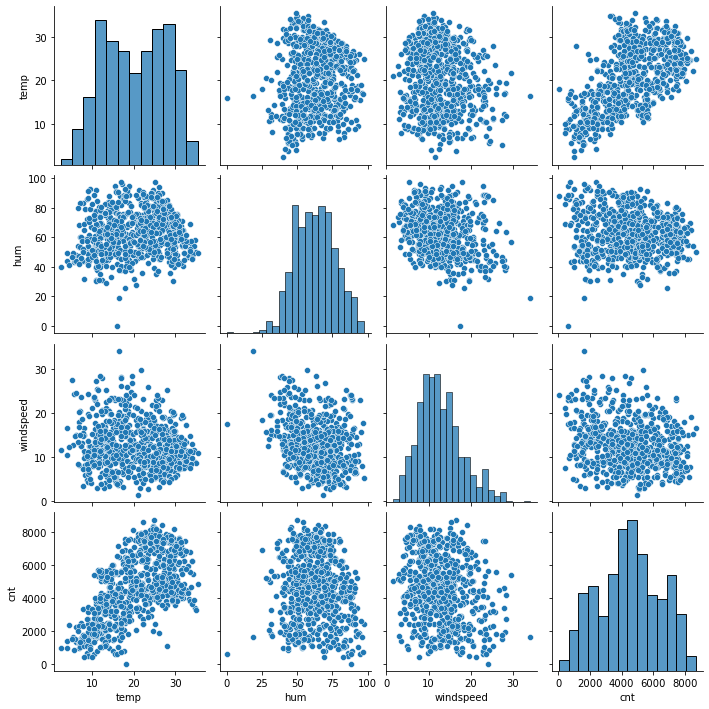

In [533]:
# viausalize numeric data against target variable
numeric_cols = ['temp', 'hum', 'windspeed', 'cnt']
sns.pairplot(day_wise_data, vars = numeric_cols)
plt.show()

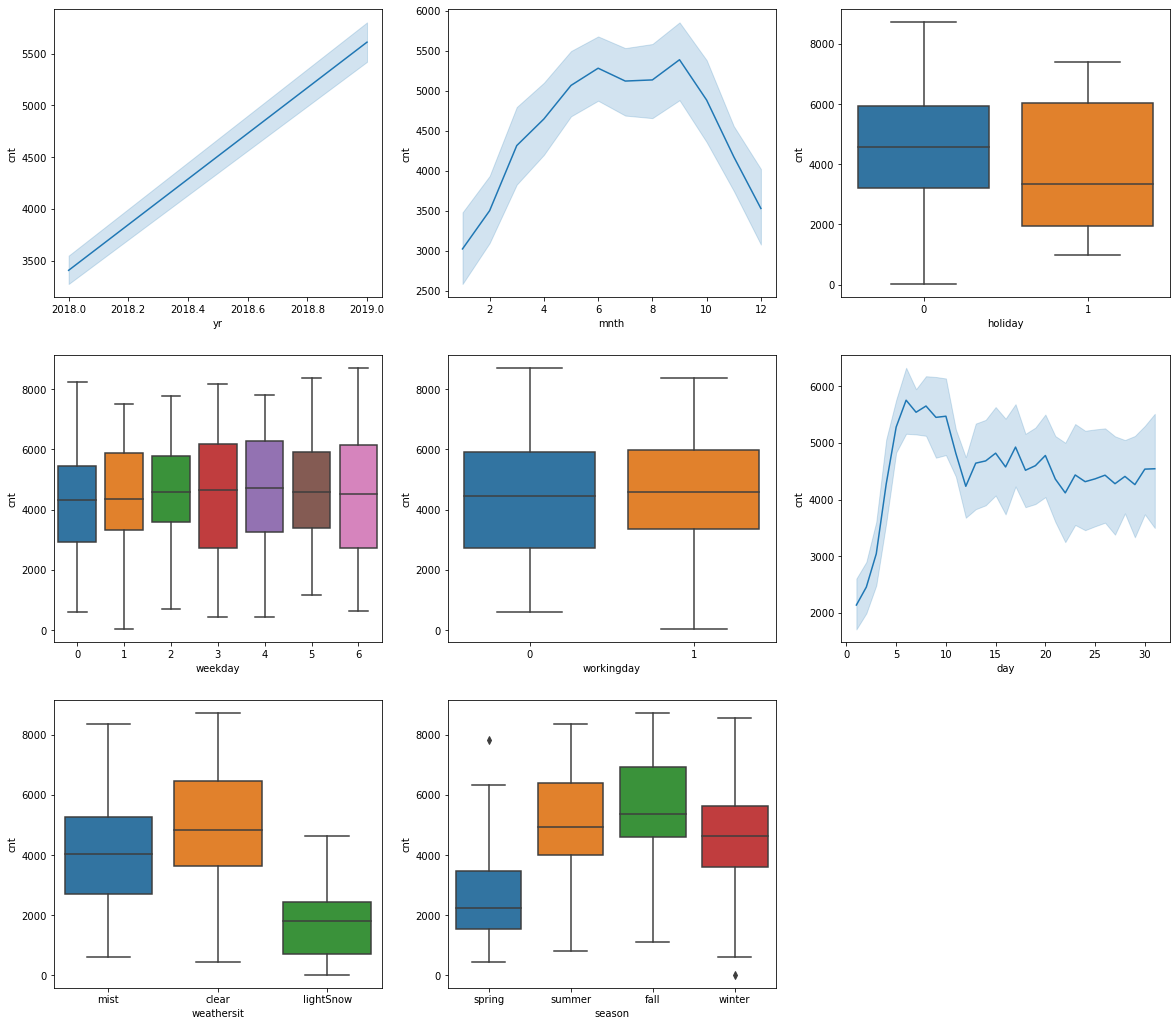

In [534]:
# visualize categorical variables against target variable
plt.figure(figsize=(20, 18))
n_rows = 3
n_cols = 3
curr_plot_ind = 1
def plotCategoricalGraphs(x, plot_type):
    """Plots graph of a given predictor vs target cnt

        Parameters
        ----------
        x : str
            name of the predictor variable
        plot_type : str
            type of plot line or box
        
    """
    
    global curr_plot_ind
    plt.subplot(n_rows,n_cols,curr_plot_ind)
    curr_plot_ind+=1
    if plot_type == 'line':
        sns.lineplot(x=x, y='cnt', data = day_wise_data)
    else: 
        sns.boxplot(x=x, y='cnt', data = day_wise_data)

plotCategoricalGraphs('yr','line')
plotCategoricalGraphs('mnth','line')
plotCategoricalGraphs('holiday','box')
plotCategoricalGraphs('weekday','box')
plotCategoricalGraphs('workingday','box')
plotCategoricalGraphs('day','line')
plotCategoricalGraphs('weathersit','box')
plotCategoricalGraphs('season','box')

### Step 3: Data Preparation
- weathersit and season have pure categorical values, we need to create dummy variables for these

In [535]:
weather_dummies = pd.get_dummies(day_wise_data['weathersit'], drop_first = True)
weather_dummies.head()

,lightSnow,mist
instant,,
1,0,1
2,0,1
3,0,0
4,0,0
5,0,0


In [536]:
season_dummies = pd.get_dummies(day_wise_data['season'], drop_first = True)
season_dummies.head()

,spring,summer,winter
instant,,,
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
5,1,0,0


In [537]:
day_wise_data = pd.concat([day_wise_data, weather_dummies], axis=1)

In [538]:
day_wise_data = pd.concat([day_wise_data, season_dummies], axis=1)

In [539]:
day_wise_data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,day,lightSnow,mist,spring,summer,winter
instant,,,,,,,,,,,,,,,,,
1,spring,2018,1,0,6,0,mist,14.110847,80.5833,10.749882,985,1,0,1,1,0,0
2,spring,2018,2,0,0,0,mist,14.902598,69.6087,16.652113,801,1,0,1,1,0,0
3,spring,2018,3,0,1,1,clear,8.050924,43.7273,16.636703,1349,1,0,0,1,0,0
4,spring,2018,4,0,2,1,clear,8.200000,59.0435,10.739832,1562,1,0,0,1,0,0
5,spring,2018,5,0,3,1,clear,9.305237,43.6957,12.522300,1600,1,0,0,1,0,0


In [540]:
#drop weatehrsit data
day_wise_data.drop(['weathersit'], axis=1, inplace=True)
day_wise_data.drop(['season'], axis=1, inplace=True)


In [541]:
day_wise_data.head()

,yr,mnth,holiday,weekday,workingday,temp,hum,windspeed,cnt,day,lightSnow,mist,spring,summer,winter
instant,,,,,,,,,,,,,,,
1,2018,1,0,6,0,14.110847,80.5833,10.749882,985,1,0,1,1,0,0
2,2018,2,0,0,0,14.902598,69.6087,16.652113,801,1,0,1,1,0,0
3,2018,3,0,1,1,8.050924,43.7273,16.636703,1349,1,0,0,1,0,0
4,2018,4,0,2,1,8.200000,59.0435,10.739832,1562,1,0,0,1,0,0
5,2018,5,0,3,1,9.305237,43.6957,12.522300,1600,1,0,0,1,0,0


## Step 4: Splitting the Data into Training and Testing Sets


In [542]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
# since we have only 710 rows of data, it is better to keep 30% as testing data to have adequate test for the model
np.random.seed(0)
train_data, test_data = train_test_split(day_wise_data, train_size = 0.7, test_size = 0.3, random_state = 100)

#### Scaling the data
- we are using Min max scaling

In [543]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
features = ['day', 'mnth', 'yr', 'weekday','temp', 'hum', 'windspeed', 'cnt']

train_data[features] = scaler.fit_transform(train_data[features])

In [544]:
train_data.head()

,yr,mnth,holiday,weekday,workingday,temp,hum,windspeed,cnt,day,lightSnow,mist,spring,summer,winter
instant,,,,,,,,,,,,,,,
654,1.0,0.818182,0,0.333333,1,0.509887,0.575354,0.300794,0.864243,0.500000,0,0,0,0,1
577,1.0,0.545455,0,0.333333,1,0.815169,0.725633,0.264686,0.827658,1.000000,0,0,0,0,0
427,1.0,0.181818,0,1.000000,0,0.442393,0.640189,0.255342,0.465255,0.066667,0,1,1,0,0
729,1.0,1.000000,0,0.000000,0,0.245101,0.498067,0.663106,0.204096,0.966667,0,0,1,0,0
483,1.0,0.272727,0,1.000000,0,0.395666,0.504508,0.188475,0.482973,0.900000,0,1,0,1,0


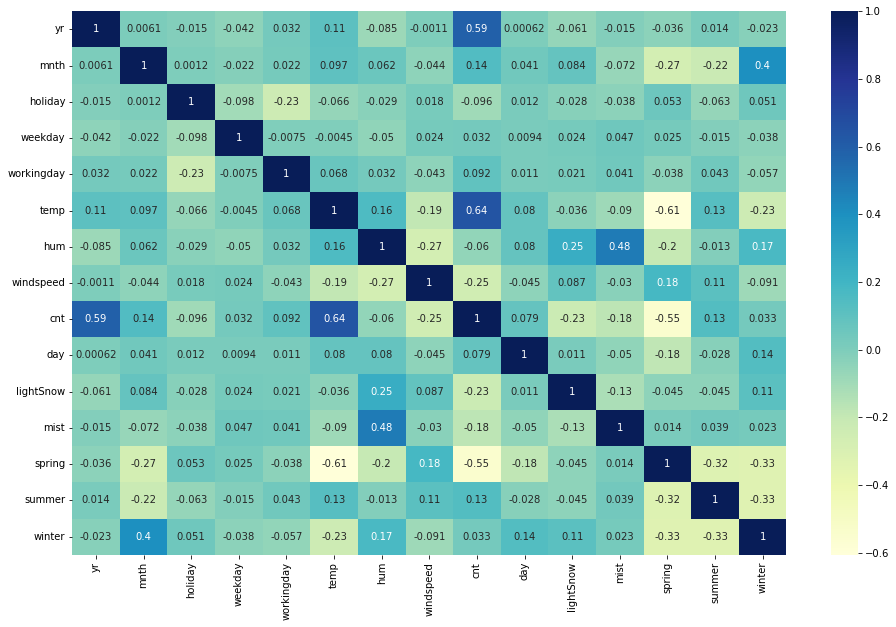

In [545]:
plt.figure(figsize = (16, 10))
sns.heatmap(train_data.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [546]:
# yr, temp, spring are having higher corelation in numbers

In [547]:
y_train = train_data.pop('cnt')
X_train = train_data

### Step 5: Building a linear model:
- RFE is being used for building model

In [548]:

# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [549]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 10)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [550]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('mnth', False, 5),
 ('holiday', True, 1),
 ('weekday', True, 1),
 ('workingday', False, 3),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('day', False, 4),
 ('lightSnow', True, 1),
 ('mist', True, 1),
 ('spring', True, 1),
 ('summer', False, 2),
 ('winter', True, 1)]

In [551]:
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'weekday', 'temp', 'hum', 'windspeed', 'lightSnow',
       'mist', 'spring', 'winter'],
      dtype='object')

In [552]:
X_train.columns[~rfe.support_]

Index(['mnth', 'workingday', 'day', 'summer'], dtype='object')

#### Building model using stats model

In [553]:
X_train_rfe = X_train[col]

In [554]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

In [555]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [556]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     241.5
Date:                Sat, 09 Jul 2022   Prob (F-statistic):          4.75e-184
Time:                        11:24:37   Log-Likelihood:                 488.53
No. Observations:                 510   AIC:                            -955.1
Df Residuals:                     499   BIC:                            -908.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3077      0.033      9.302      0.0

 holiday, hum have high probability lets check VIF also

In [558]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor
def show_vif(training_data):
    """calculates and prints variance infltion factor

        Parameters
        ----------
        X_train : pandas series
            training data to clacluate vif.
        
    """
    training_data = training_data.drop(['const'], axis=1)
    vif = pd.DataFrame()
    X = training_data
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

show_vif(X_train_rfe)

    Features    VIF
4        hum  21.75
3       temp  13.37
5  windspeed   4.01
2    weekday   3.09
8     spring   2.58
7       mist   2.23
9     winter   2.10
0         yr   2.05
6  lightSnow   1.20
1    holiday   1.05


In [559]:
#VIF is very high for humidity, temp and p value is also high for hum hence drop it.
X_train_rfe.drop(["hum"], axis = 1, inplace=True)
X_train_new = X_train_rfe

In [482]:
# Adding a constant variable 
#import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     263.6
Date:                Sat, 09 Jul 2022   Prob (F-statistic):          1.74e-183
Time:                        11:19:17   Log-Likelihood:                 484.31
No. Observations:                 510   AIC:                            -948.6
Df Residuals:                     500   BIC:                            -906.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2441      0.025      9.822      0.0

In [560]:
show_vif(X_train_new)

    Features   VIF
3       temp  4.35
4  windspeed  3.99
2    weekday  3.06
0         yr  2.05
7     spring  1.76
6       mist  1.51
8     winter  1.41
5  lightSnow  1.08
1    holiday  1.05


In [564]:
# holiday is having a p value of 0.003
# let us drop it and see
X_train_rfe.drop(["holiday"], axis = 1, inplace=True)
X_train_new = X_train_rfe

In [565]:
# Calculate the VIFs for the new data
show_vif(X_train_new)

    Features   VIF
2       temp  4.33
3  windspeed  3.98
1    weekday  3.04
0         yr  2.05
6     spring  1.74
5       mist  1.50
7     winter  1.39
4  lightSnow  1.08


In [566]:
# Adding a constant variable 
#import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     291.0
Date:                Sat, 09 Jul 2022   Prob (F-statistic):          7.13e-183
Time:                        11:27:06   Log-Likelihood:                 479.93
No. Observations:                 510   AIC:                            -941.9
Df Residuals:                     501   BIC:                            -903.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2409      0.025      9.629      0.0

## Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [567]:
y_train_demand = lm.predict(X_train_lm)

In [568]:
# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 0, 'Errors')

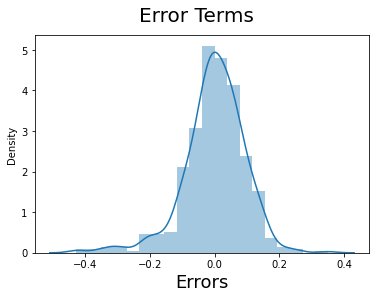

In [576]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_demand), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

## Making Predictions

In [570]:
#features = ['temp', 'windspeed', 'casual','yr','spring','winter','lightSnow']
test_data[features] = scaler.transform(test_data[features])

In [571]:
y_test = test_data.pop('cnt')
X_test = test_data

In [572]:
# Now let's use our model to make predictions.
features = X_train_lm
features.drop('const', axis=1, inplace=True)
# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[features.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [573]:
# Making predictions
y_pred = lm.predict(X_test_new)

## Model Evaluation

Text(0, 0.5, 'y_pred')

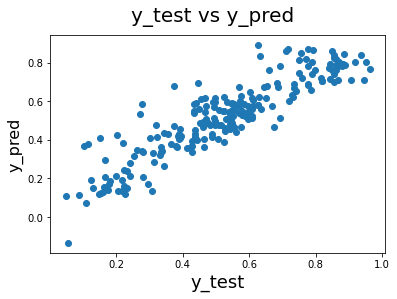

In [574]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

#### Residual analysis on test data
-Lets see if our assumption of normally distributed error terms still valid on test data also

Text(0.5, 0, 'Errors')

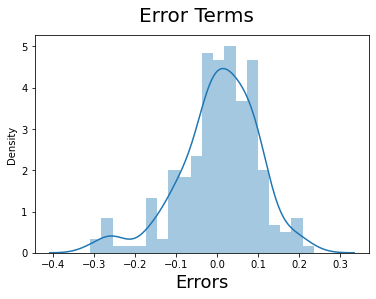

In [575]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_test - y_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)           

In [578]:
# error terms are normally distributed.
# model explains our assumption.